In [1]:
import sys
sys.path.insert(0, "../lib")

In [2]:
import math
import os
import pathlib
import re

import scanpy as sc
import numpy as np
import pandas as pd
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [5]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# mpl.rcParams['mathtext.default'] = 'regular'


In [6]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        if pd.api.types.is_numeric_dtype(df[column]):
            values = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
            if not isinstance(palette, mpl.colors.Colormap):
                palette = sns.color_palette(palette, as_cmap=True)
            colors = palette(values)
            colors = [mpl.colors.to_hex(color) for color in colors]
            colors = pd.Series(colors, index=values.index, name=column)
        else:
            lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
            colors = df[column].map(lut)
        result.append(colors)
    return pd.concat(result, axis=1)

In [7]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [8]:
adata = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [9]:
adata.obs.cell_type = adata.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [10]:
adata.obs.Status = pd.Categorical(adata.obs.Status.astype(str).replace({
    'control': 'Control',
    'SSc': 'SSc-ILD'
}), categories=['Control', 'SSc-ILD'])

In [11]:
rng = np.random.default_rng(seed=101)
adata.uns['cell_type_colors'] = list(rng.permutation(
    adata.uns['cell_type_colors']
))

In [12]:
paper_ids = pd.read_csv('../SSc_BAL_GEO_ID_Mapping - ID mapping.csv')

In [27]:
adata.obs['paper_id'] = paper_ids.set_index('External Sample ID')['Publication ID'][
    adata.obs['External Sample ID'].values
].values
adata.obs['paper_id'] = pd.Categorical(adata.obs['paper_id'])

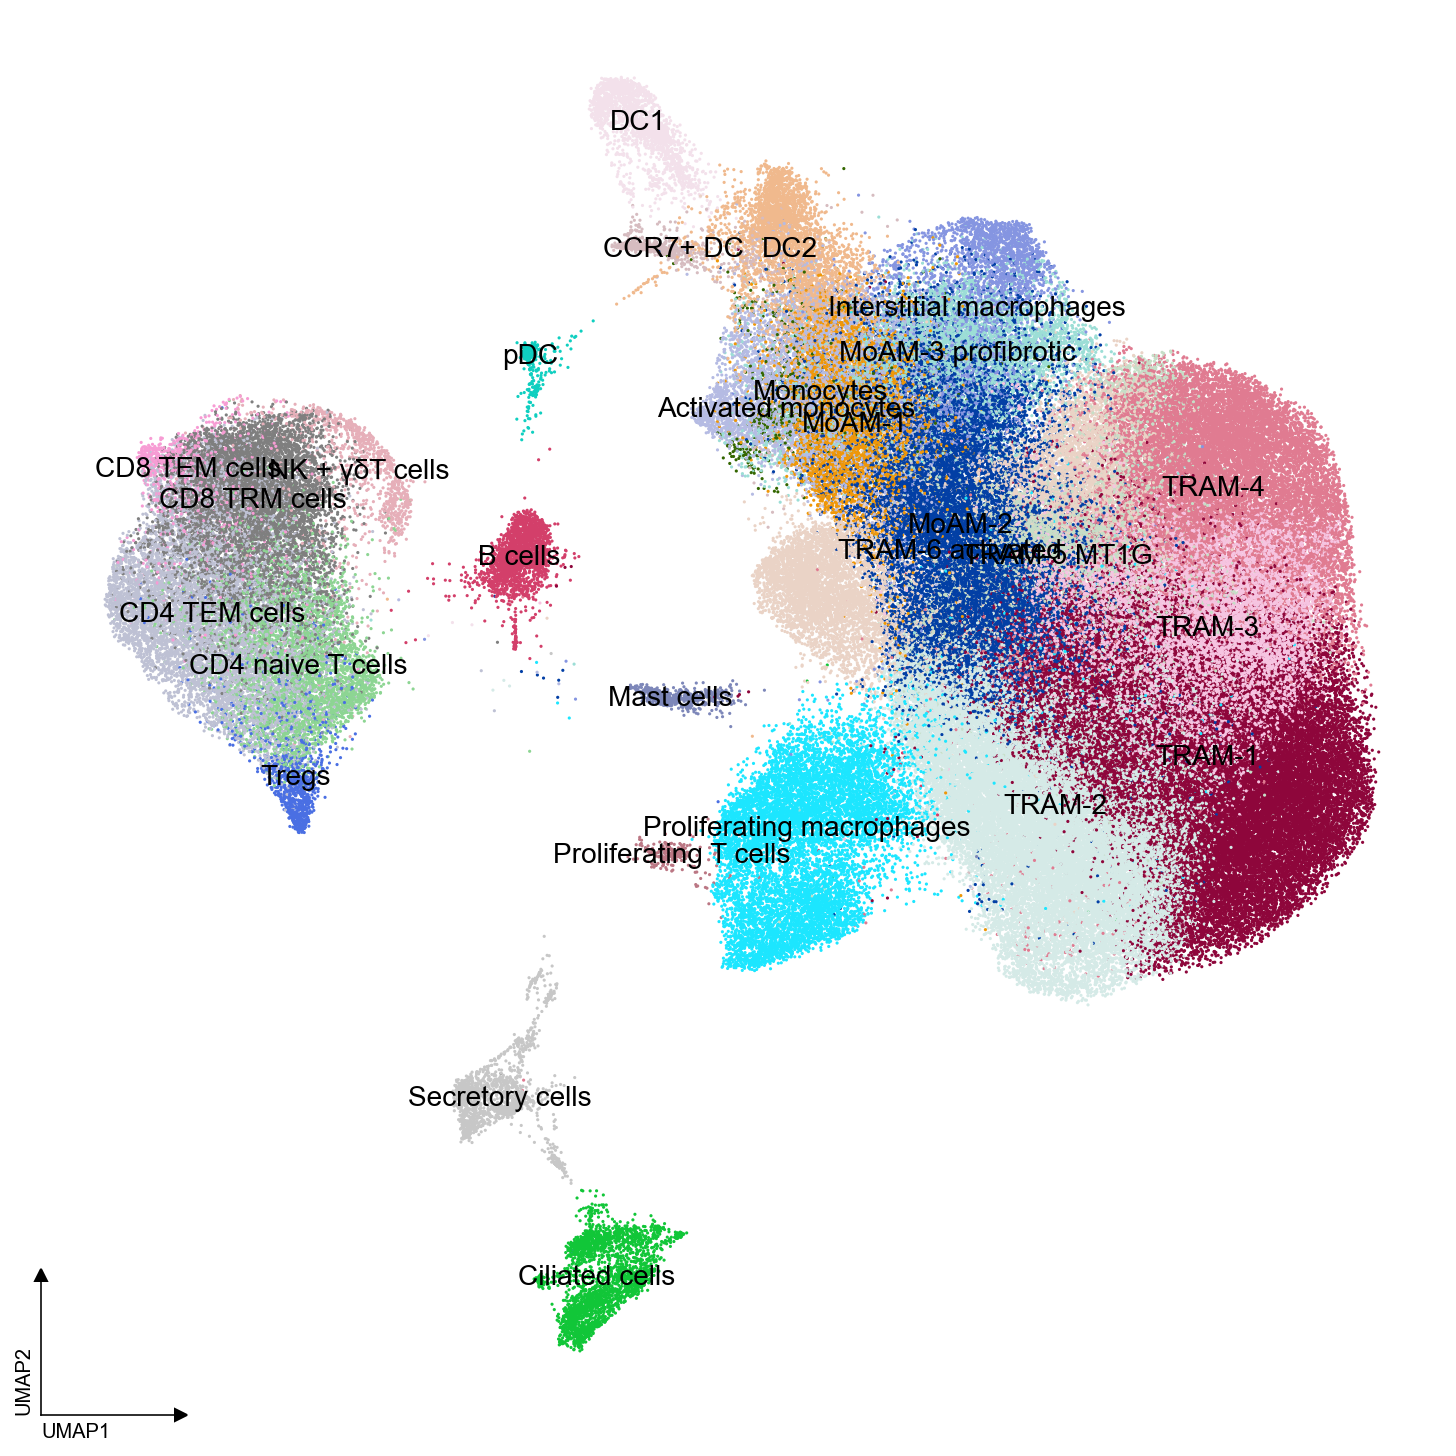

In [12]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
sc.pl.umap(
    adata,
    color='cell_type',
    legend_loc='on data',
    ax=ax,
    legend_fontweight='normal',
    legend_fontsize=14,
    title='',
    show=False,
    size=10
)
shrink_by = 0.1
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xbound = xlim[0] + (xlim[1] - xlim[0]) * shrink_by
ybound = ylim[0] + (ylim[1] - ylim[0]) * shrink_by

b = ax.spines["bottom"]
b.set_bounds(xlim[0], xbound)
ax.set_xlabel(ax.get_xlabel(), x=0, ha="left")
ax.plot(xbound, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False)

b = ax.spines["left"]
b.set_bounds(ylim[0], ybound)
ax.set_ylabel(ax.get_ylabel(), y=0, ha="left")
ax.plot(0, ybound, "^k", transform=ax.get_yaxis_transform(), clip_on=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.collections[0].set_rasterized(True)
fig.savefig('00_figures/Figure_2A_umap.pdf', dpi=300)

In [16]:
CELL_TYPES_ORDER = [
    'Monocytes',
    'Activated monocytes',

    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',

    'TRAM-1',
    'TRAM-2',
    'TRAM-3',
    'TRAM-4',
    'TRAM-5 MT1G',
    'TRAM-6 activated',

    'Interstitial macrophages',
    'Proliferating macrophages',

    'CD4 TEM cells',
    'CD4 naive T cells',
    'Tregs',
    'CD8 TEM cells',
    'CD8 TRM cells',
    'NK + γδT cells',
    'Proliferating T cells',

    'DC1',
    'DC2',
    'CCR7+ DC',
    'pDC',

    'B cells',
    'Mast cells',

    'Ciliated cells',
    'Secretory cells',
]

In [17]:
markers = pd.read_csv(DATA / '03_bal-object/03_bal-object-markers.csv', index_col=0)

In [18]:
markers.cluster = markers.cluster.replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
})

In [19]:
markers.cluster = pd.Categorical(markers.cluster, categories=CELL_TYPES_ORDER)

In [20]:
markers = markers.sort_values(['cluster', 'avg_logFC'], ascending=[True, False])

In [21]:
markers.to_csv('00_figures/Table_S1_markers.csv', index=False)

In [22]:
top5 = markers.groupby('cluster').head(5)

In [19]:
THRESHOLD = 25
pseudobulk = []
meta = []
for sample in adata.obs['External Sample ID'].unique():
    for ct in adata.obs.cell_type.unique():
        idx = adata.obs['External Sample ID'].eq(sample) & adata.obs.cell_type.eq(ct)
        if idx.sum() < THRESHOLD:
            continue
        pseudobulk.append(adata.raw.X[idx][:, adata.raw.var_names.isin(top5.gene)].mean(axis=0).A1)
        meta.append((sample, ct))
pseudobulk = pd.DataFrame(
    pseudobulk,
    columns=adata.raw.var_names[adata.raw.var_names.isin(top5.gene)]
)
meta = pd.DataFrame(meta, columns=('sample', 'cell_type'))

In [20]:
cell_types_samples = meta.groupby('cell_type').size()
cell_types_to_keep = cell_types_samples.index[cell_types_samples.gt(3)]

In [21]:
# redefine to remove markers for cell types which we won't show
top5 = markers.loc[markers.cluster.isin(cell_types_to_keep)].groupby('cluster').head(5)

In [22]:
pseudobulk = pseudobulk.loc[:, pseudobulk.columns[pseudobulk.columns.isin(top5.gene)]]

In [23]:
meta = meta.loc[meta.cell_type.isin(cell_types_to_keep)].copy()

In [24]:
sample_to_status = adata.obs[
    ['External Sample ID', 'Status']
].drop_duplicates().set_index('External Sample ID').Status

In [25]:
meta['Status'] = sample_to_status[meta['sample']].values

In [26]:
meta.Status = pd.Categorical(meta.Status, ['Control', 'SSc-ILD'])

In [27]:
meta.cell_type = pd.Categorical(meta.cell_type, categories=CELL_TYPES_ORDER)
# meta.cell_type = meta.cell_type.cat.remove_unused_categories()

In [28]:
meta = meta.sort_values(['cell_type', 'Status', 'sample'])

In [29]:
cell_type_colors = []
for ct in meta.cell_type.cat.categories:
    ct_idx = adata.obs.cell_type.cat.categories.get_loc(ct)
    cell_type_colors.append(adata.uns['cell_type_colors'][ct_idx])

In [30]:
col_colors_df = get_color_annotations(meta, {
    # 'sample': 'tab20',
    'cell_type': cell_type_colors,
    'Status': ['royalblue', 'firebrick'],
})

In [31]:
legend_handles = {}
for l in ('cell_type',):
    legend_handles[l] = []
    labels = meta[[l]].drop_duplicates().sort_values(l)
    colors = col_colors_df.loc[labels.index, l]
    for label, color in zip(labels[l], colors):
        legend_handles[l].append(mpl.patches.Patch(
            label=label,
            color=color
        ))

In [32]:
genes_to_plot = top5.gene.drop_duplicates().tolist()

In [33]:
genes_to_plot.remove('AC064834.3')

In [34]:
genes_to_plot.remove('RP11-291B21.2')

In [35]:
genes_to_plot.remove('AL928768.3')

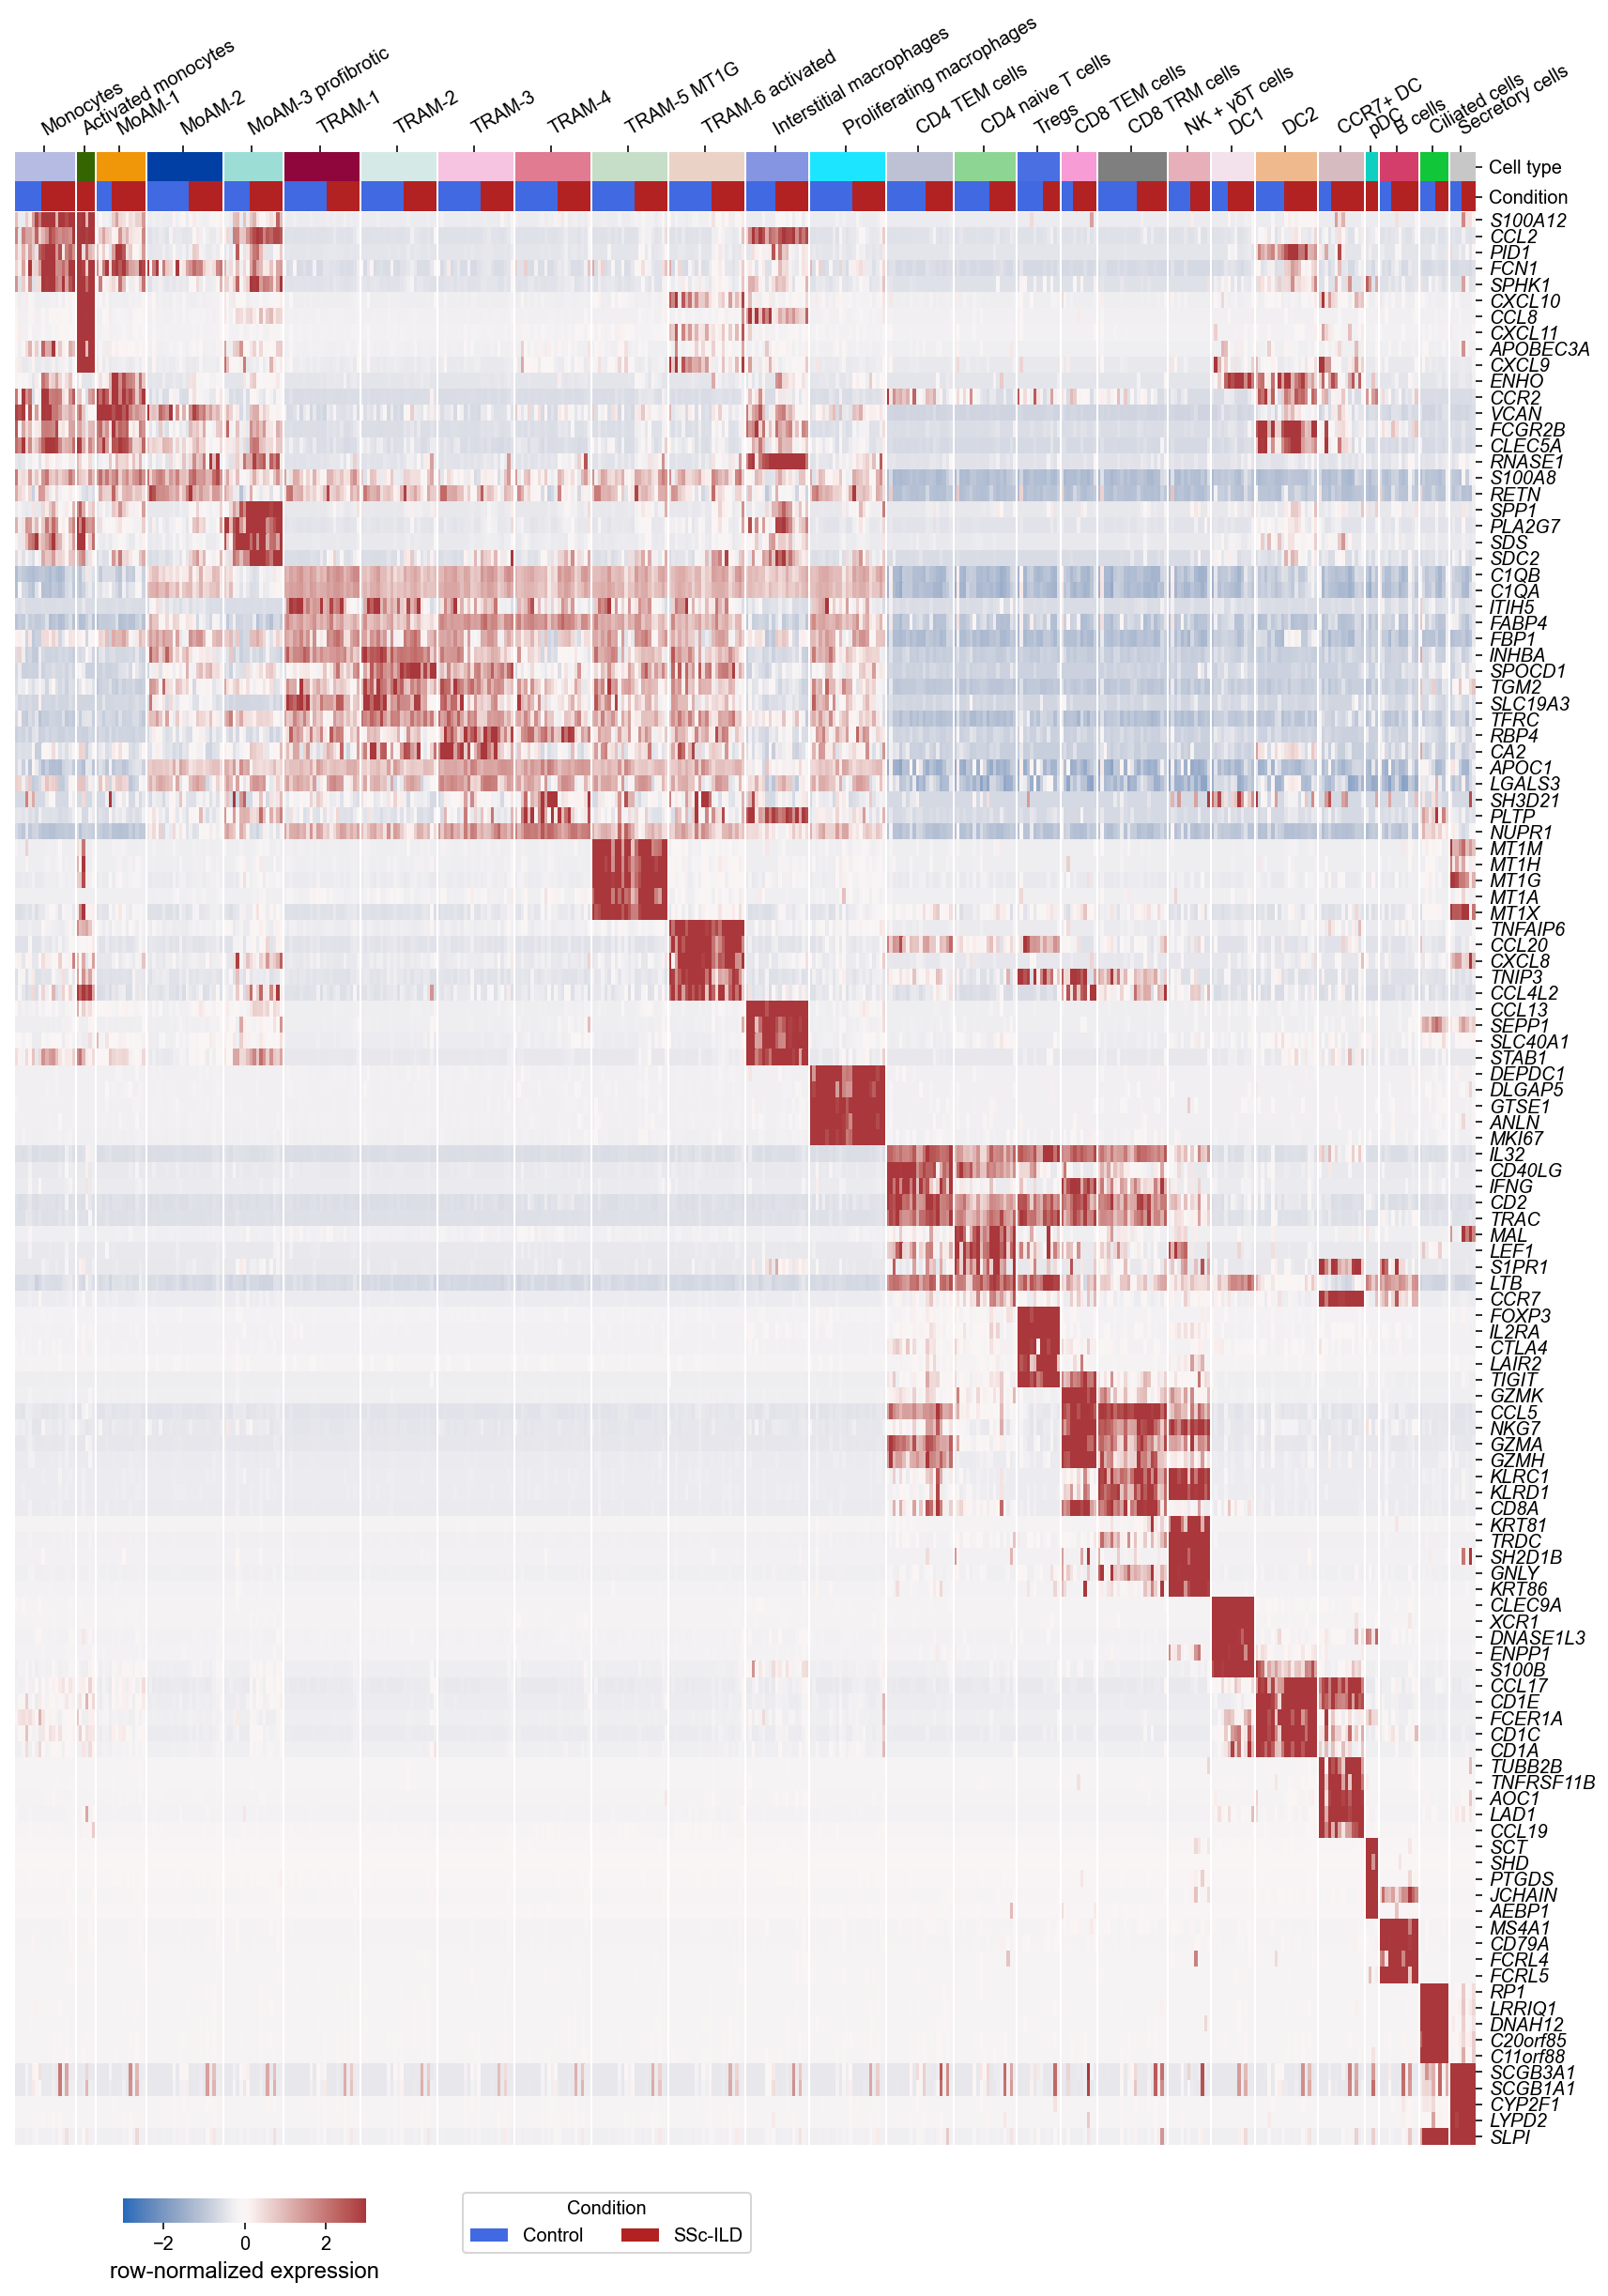

In [37]:
cg = sns.clustermap(
    pseudobulk.T.loc[genes_to_plot, meta.index],
    col_colors=col_colors_df,
    col_cluster=False,
    row_cluster=False,
    figsize=(12, 18),
    z_score=0,
    cmap='vlag',
    center=0,
    vmin=-3,
    vmax=3,
    dendrogram_ratio=0.001,
    colors_ratio=0.015,
    cbar_kws=dict(
        label='row-normalized expression',
        orientation='horizontal'
    ),
    xticklabels=[],
    yticklabels=genes_to_plot,
)

cg.ax_col_colors.set_xticks(
    meta.reset_index(drop=True).reset_index().groupby('cell_type').index.mean()
)
cg.ax_col_colors.set_xticklabels(
    meta.cell_type.cat.categories,
)
cg.ax_col_colors.set_yticklabels(['Cell type', 'Condition'])
cg.ax_col_colors.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True, rotation=30)
trans = mpl.transforms.Affine2D().translate(-5, 0)
for t in cg.ax_col_colors.get_xticklabels():
    t.set_ha('left')
    t.set_transform(t.get_transform() + trans)
cg.ax_heatmap.legend(
    handles=[
        mpl.patches.Patch(fc='royalblue', label='Control'),
        mpl.patches.Patch(fc='firebrick', label='SSc-ILD'),
    ],
    loc='upper left',
    bbox_to_anchor=(0.3, -0.02),
    title='Condition',
    ncol=2
)

for ct in meta.cell_type.unique()[1:]:
    ct_loc = meta.index.get_loc(meta.index[meta.cell_type.eq(ct)][0])
    cg.ax_heatmap.axvline(ct_loc, color='w', lw=1)
    cg.ax_col_colors.axvline(ct_loc, color='w', lw=1)

cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontstyle='italic')
cg.ax_heatmap.tick_params(labelsize=10)

cg.fig.subplots_adjust(bottom=0.08, top=0.9)

cg.ax_cbar.set_position((0.08, 0.048, 0.15, 0.01))
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=12)

cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_2B_markers.pdf', dpi=300)

In [ ]:
MOAMS = [
    'Monocytes',
    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',
    'Interstitial macrophages',
]

In [41]:
genes_to_plot = [
    'S100A12',
    'CCL2',
    'PID1',
    'FCN1',
    'SPHK1',
    'CD93',
    'CD300E',
    'CST6',
    'CLEC5A',
    'VEGFA',
    'ENHO',
    'CCR2',
    'VCAN',
    'FCGR2B',
    'EMP1',
    'CDA',
    'CRIP2',
    'RNASE1',
    'S100A8',
    'RETN',
    'PLAC8',
    'CYBB',
    'S100A9',
    'APOE',
    'SPP1',
    'PLA2G7',
    'SDS',
    'SDC2',
    'CCL3',
    'FAM198B',
    'MATK',
    'A2M',
    'C1QB',
    'C1QA',
    'ITIH5',
    'FABP4',
    'PPARG',
    'FBP1',
    'C1QC',
    'HP',
    'MCEMP1',
    'PCOLCE2',
    'MARCO',
    'CCL13',
    'SEPP1',
    'SLC40A1',
    'STAB1',
    'GAL3ST4',
    'F13A1',
    'LILRB5',
    'MERTK'
]

In [ ]:
THRESHOLD = 25
pseudobulk = []
meta = []
for sample in adata.obs['External Sample ID'].unique():
    for ct in MOAMS:
        idx = adata.obs['External Sample ID'].eq(sample) & adata.obs.cell_type.eq(ct)
        if idx.sum() < THRESHOLD:
            continue
        pseudobulk.append(adata.raw.X[idx][:, adata.raw.var_names.isin(genes_to_plot)].mean(axis=0).A1)
        meta.append((sample, ct))
pseudobulk = pd.DataFrame(
    pseudobulk,
    columns=adata.raw.var_names[adata.raw.var_names.isin(genes_to_plot)]
).loc[:, genes_to_plot]
meta = pd.DataFrame(meta, columns=('sample', 'cell_type'))

In [43]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [44]:
sample_to_status = adata.obs[
    ['External Sample ID', 'Status']
].drop_duplicates().set_index('External Sample ID').Status

In [45]:
meta['Status'] = sample_to_status[meta['sample']].values

In [46]:
meta.Status = pd.Categorical(meta.Status, ['Control', 'SSc-ILD'])

In [47]:
meta.cell_type = pd.Categorical(meta.cell_type, MOAMS)

In [48]:
meta = meta.sort_values(['cell_type', 'Status'])

In [49]:
cell_type_colors = []
for ct in meta.cell_type.cat.categories:
    ct_idx = adata.obs.cell_type.cat.categories.get_loc(ct)
    cell_type_colors.append(adata.uns['cell_type_colors'][ct_idx])

In [50]:
col_colors_df = get_color_annotations(meta, {
    # 'sample': 'tab20',
    'cell_type': cell_type_colors,
    'Status': ['royalblue', 'firebrick'],
})

In [51]:
plot_df = pseudobulk.T.loc[genes_to_plot, meta.index]
max_sort = np.argsort(np.argmax(plot_df.values, axis=1))
plot_df = plot_df.iloc[max_sort, :]

In [52]:
genes_to_plot = [
    'CLEC5A',
    'S100A12',
    'SPHK1',
    'PID1',
    'FCN1',
    'CD93',
    'CD300E',
    'EMP1',
    'CCL2',
    'VEGFA',
    'CYBB',
    'CCR2',
    'VCAN',
    'CRIP2',
    'CST6',
    'FCGR2B',
    'ENHO',
    'CDA',
    'FABP4',
    'PPARG',
    'MCEMP1',
    'S100A9',
    'C1QA',
    'APOE',
    'ITIH5',
    'PLAC8',
    'MARCO',
    'S100A8',
    'RETN',
    'PCOLCE2',
    'FBP1',
    'SDS',
    'CCL3',
    'SDC2',
    'PLA2G7',
    'SPP1',
    'MATK',
    'SEPP1',
    'LILRB5',
    'F13A1',
    'MERTK',
    'STAB1',
    'RNASE1',
    'SLC40A1',
    'GAL3ST4',
    'CCL13'
]

In [53]:
plot_df = plot_df.loc[genes_to_plot]

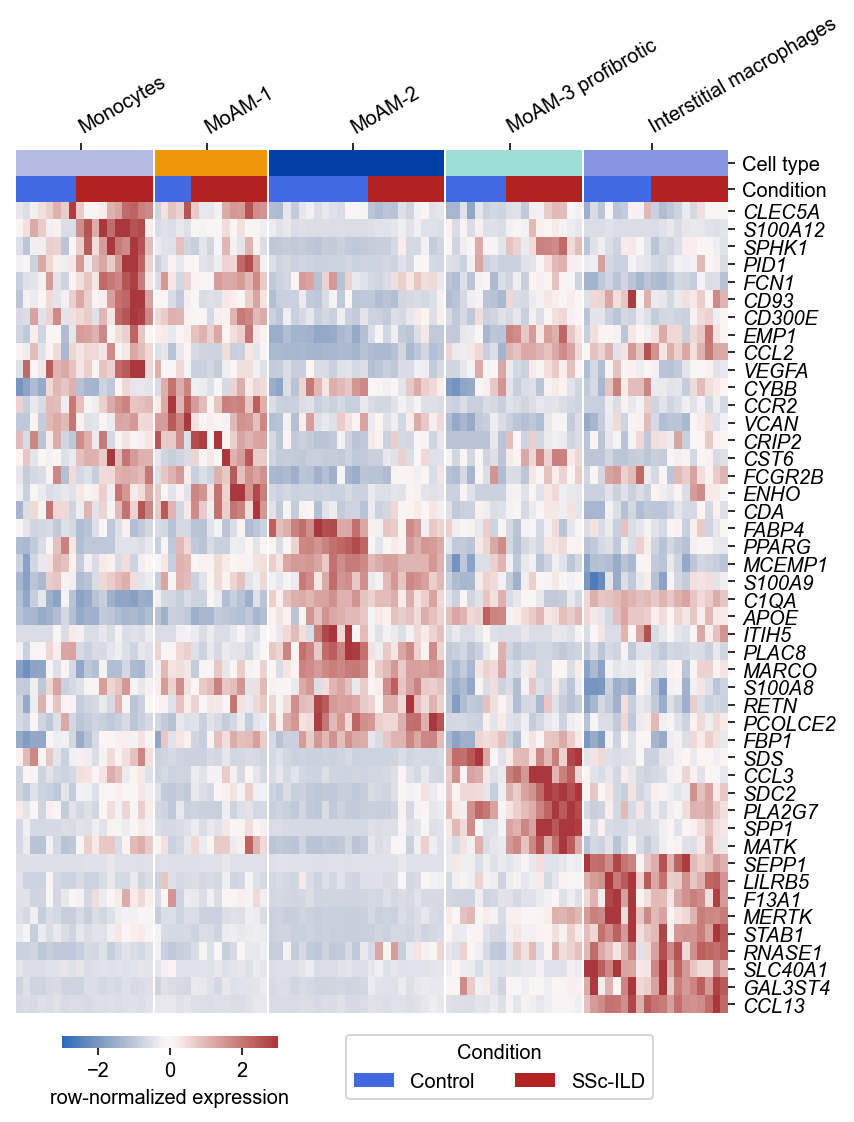

In [54]:
cg = sns.clustermap(
    plot_df,
    col_colors=col_colors_df,
    col_cluster=False,
    row_cluster=False,
    figsize=(6, 8),
    cmap='vlag',
    center=0,
    vmin=-3,
    vmax=3,
    dendrogram_ratio=0.001,
    colors_ratio=0.03,
    cbar_kws=dict(
        label='row-normalized expression',
        orientation='horizontal'
    ),
    xticklabels=[],
    yticklabels=plot_df.index,
)

cg.ax_col_colors.set_xticks(
    meta.reset_index(drop=True).reset_index().groupby('cell_type').index.mean()
)

cg.ax_col_colors.set_xticklabels(
    meta.cell_type.cat.categories,
)

cg.ax_col_colors.set_yticklabels(['Cell type', 'Condition'])
cg.ax_col_colors.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True, rotation=30)
trans = mpl.transforms.Affine2D().translate(-5, 0)
for t in cg.ax_col_colors.get_xticklabels():
    t.set_ha('left')
    t.set_transform(t.get_transform() + trans)
cg.ax_heatmap.legend(
    handles=[
        mpl.patches.Patch(fc='royalblue', label='Control'),
        mpl.patches.Patch(fc='firebrick', label='SSc-ILD'),
    ],
    loc='upper left',
    bbox_to_anchor=(0.45, -0.015),
    title='Condition',
    ncol=2
)

for ct in meta.cell_type.unique()[1:]:
    ct_loc = meta.index.get_loc(meta.index[meta.cell_type.eq(ct)][0])
    cg.ax_heatmap.axvline(ct_loc, color='w', lw=1)
    cg.ax_col_colors.axvline(ct_loc, color='w', lw=1)

cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontstyle='italic')
cg.ax_heatmap.tick_params(labelsize=10)

cg.fig.subplots_adjust(bottom=0.1, top=0.85)

cg.ax_cbar.set_position((0.08, 0.07, 0.25, 0.01))
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=10)

cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)

cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_2C_mac_markers.pdf', dpi=300)

## Plot compositions

In [23]:
adata.obs.columns

Index(['Study', 'Sample', 'Sample ID', 'External Sample ID', 'Status',
       'Patient', 'Age', 'Sex', 'Smoking status', 'Race', 'BMI', 'Type',
       'Tissue location', 'Additional data', 'Chemistry', 'Protocol', 'Fastq',
       'Genome build', 'Directory', 'Doublet threshold', 'batch', 'n_counts',
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes',
       'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels',
       'leiden_scVI', 'cell_type', 'paper_id'],
      dtype='object')

In [25]:
COMPOSITION_VARS = {
    'paper_id': None,
    'Status': ['royalblue', 'firebrick'],
    'Sex': ["#df8ea9", "#7eaedf"],
    'Study': ['#ccc', '#666'],
    'Chemistry': ['#c49958', '#8c8c8c'],
    'Protocol': ['#8c58d3', '#58d3c4'],
}
NAMES = {
    'paper_id': 'Sample',
    'Status': 'Condition',
    'Study': 'Cohort',
}
LABELS = {
    'Sex': {
        'male': 'Male',
        'female': 'Female'
    },
    'Study': {
        'this': 'Northwestern/Yale'
    },
    'Protocol': {
        'FACSorted': 'FACS',
        'Wash, no sorting': 'no FACS'
    }
}

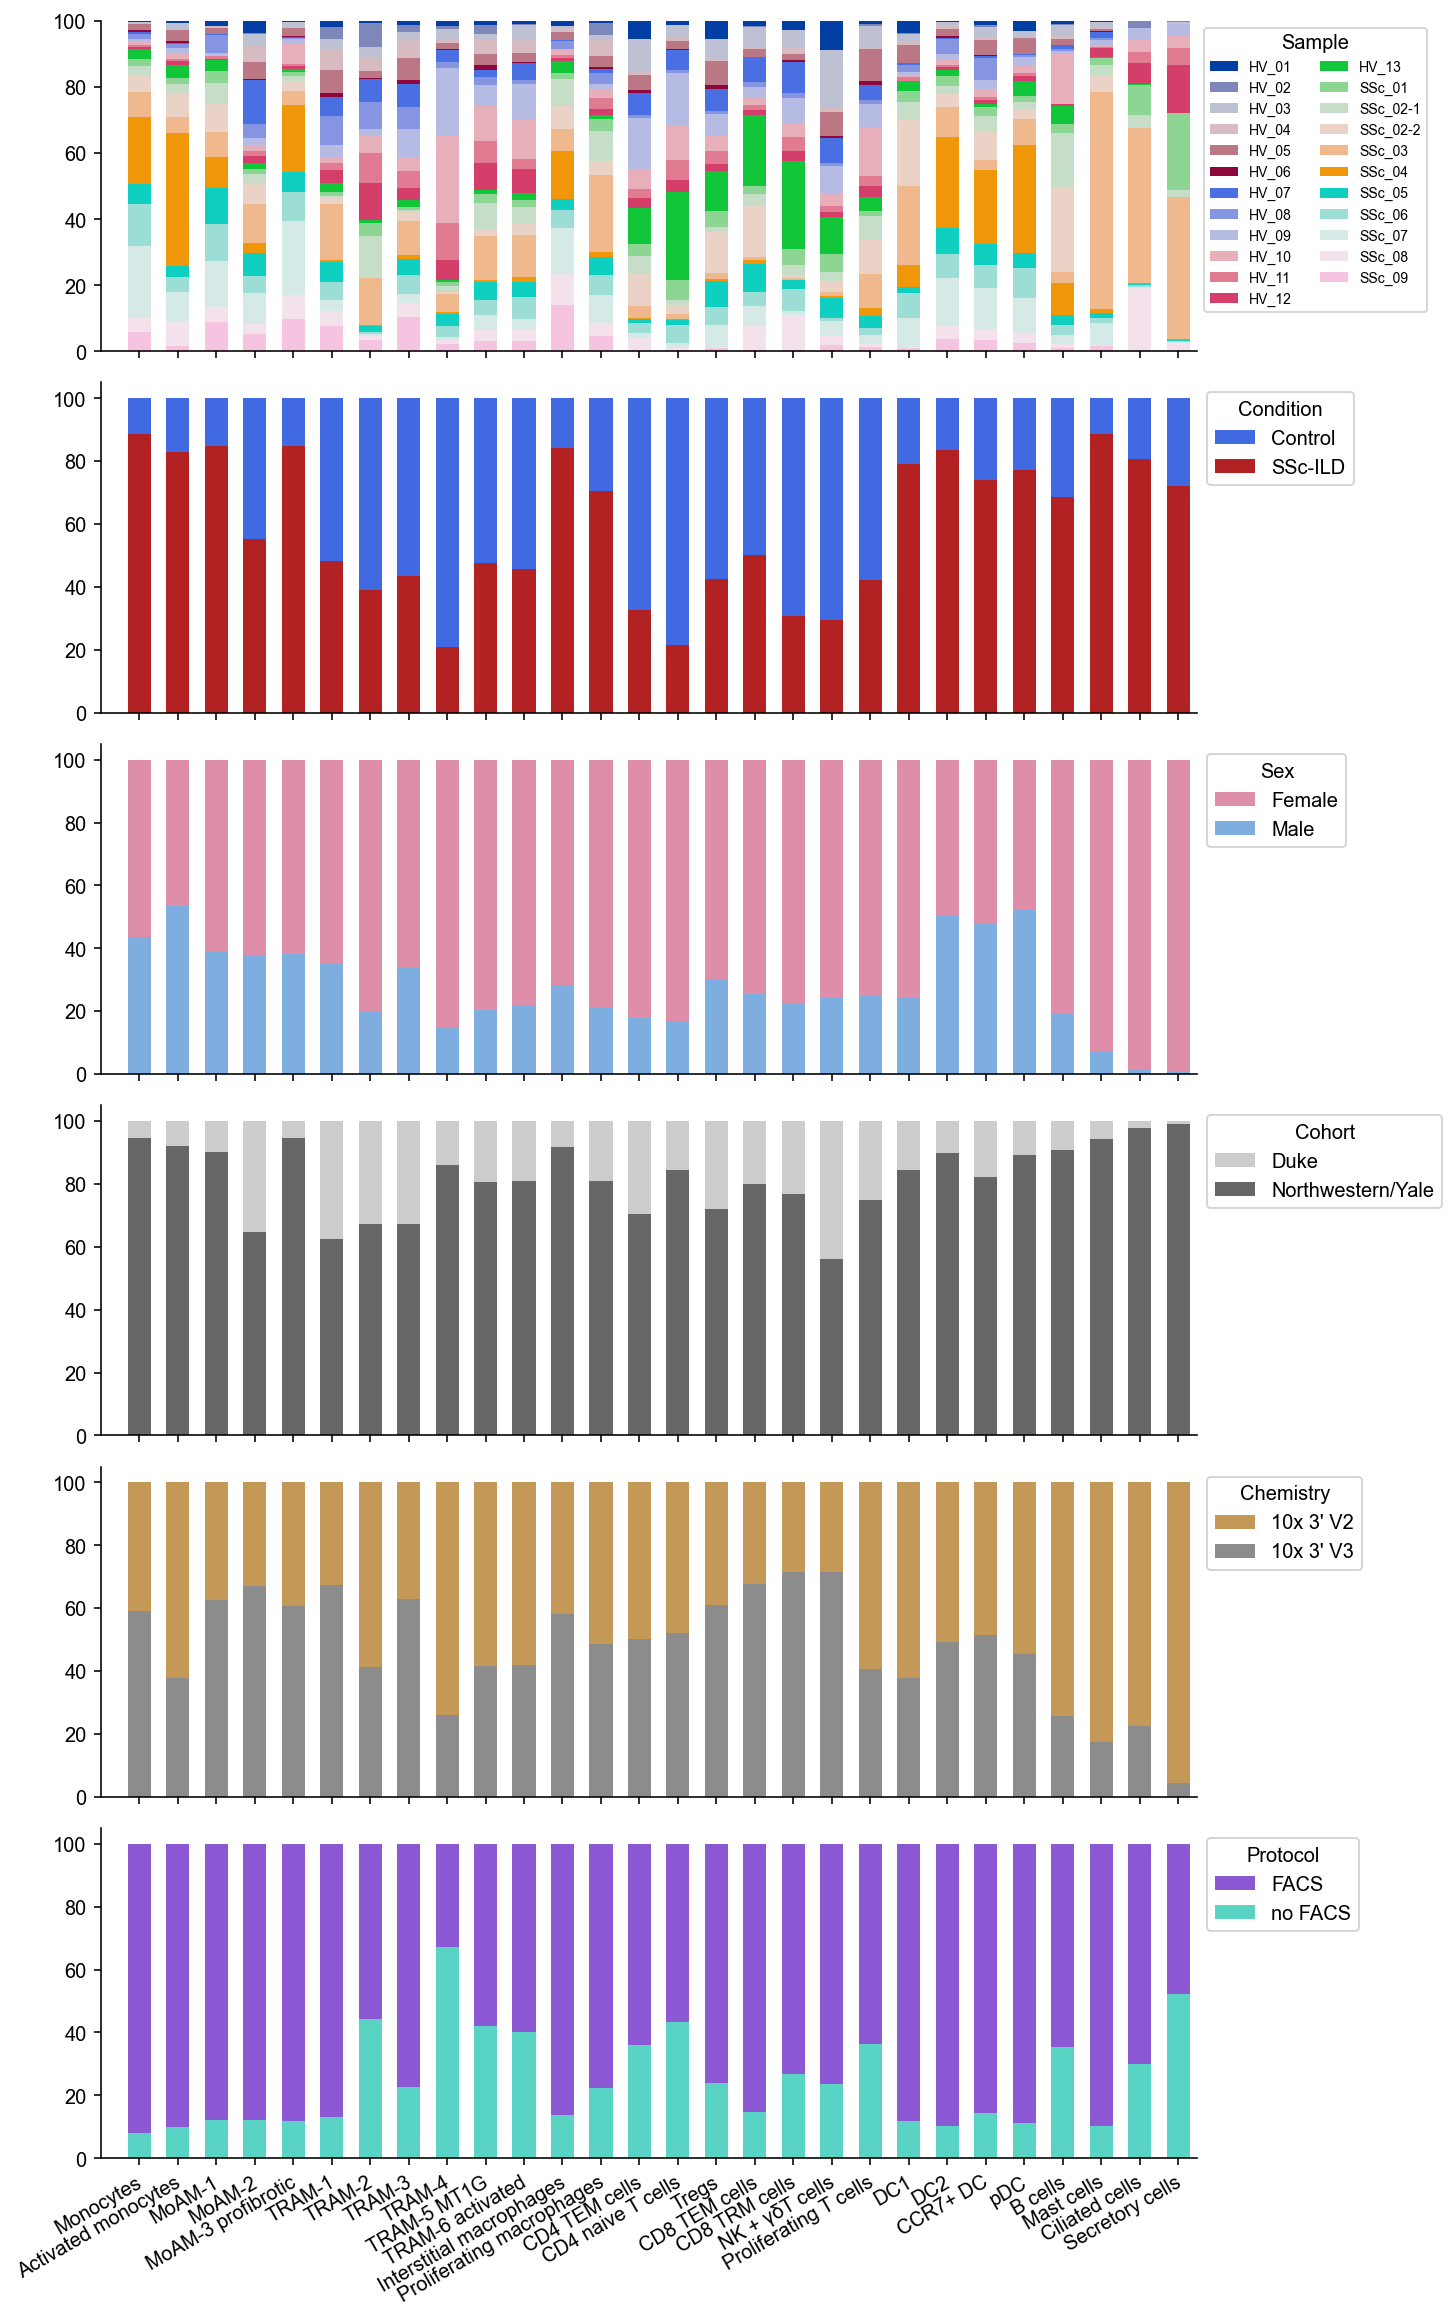

In [28]:
fig, axes = plt.subplots(figsize=(10, 16), constrained_layout=True, nrows=len(COMPOSITION_VARS), ncols=1, sharex=True)

group_by = 'cell_type'
for i, (var, palette) in enumerate(COMPOSITION_VARS.items()):
    ax = axes[i]

    bottom = np.zeros(len(adata.obs[group_by].unique()))
    total = None
    total = adata.obs[group_by].value_counts().sort_index(ascending=False)
    total = total.loc[CELL_TYPES_ORDER]

    num_colors = adata.obs[var].unique().size

    if palette is None:
        if num_colors <= 10:
            colors = mpl.cm.tab10
        elif num_colors <= 20:
            colors = mpl.cm.tab20
        elif num_colors <= 28:
            colors = sc.pl.palettes.default_28
        else:
            colors = sc.pl.palettes.default_102
    else:
        colors = palette

    for j, s in enumerate(reversed(adata.obs[var].cat.categories)):
        cnt = adata.obs[group_by][adata.obs[var] == s].value_counts().sort_index(ascending=False)
        cnt = cnt.loc[CELL_TYPES_ORDER]
        cnt = cnt / total * 100
        # sample colors from the first
        color_j = num_colors - j - 1
        c = isinstance(colors, list) and colors[color_j] or colors(color_j)
        label = LABELS.get(var, {}).get(s, s)
        ax.bar(cnt.index, cnt, bottom=bottom, label=label, color=c, width=0.6)
        bottom += cnt

    n_legend_cols = 1
    legend_fontsize = 10
    if num_colors > 10:
        n_legend_cols = 2
        legend_fontsize = 7
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i == len(COMPOSITION_VARS) - 1:
        ax.tick_params(axis='x', rotation=30, labelsize=10)
        trans = mpl.transforms.Affine2D().translate(6, 0)
        for t in ax.get_xticklabels():
            t.set_ha('right')
            t.set_transform(t.get_transform() + trans)
    h, l = ax.get_legend_handles_labels()
    ax.legend(
        handles=reversed(h),
        labels=reversed(l),
        title=NAMES.get(var, var.capitalize()),
        loc='upper left',
        bbox_to_anchor=(1, 1),
        fontsize=legend_fontsize,
        ncol=n_legend_cols
    )
    ax.set_xlim(-1, len(total) - 0.5)

fig.savefig('00_figures/Figure_S1D_composition.pdf')

# Explore MoAM-3 cluster

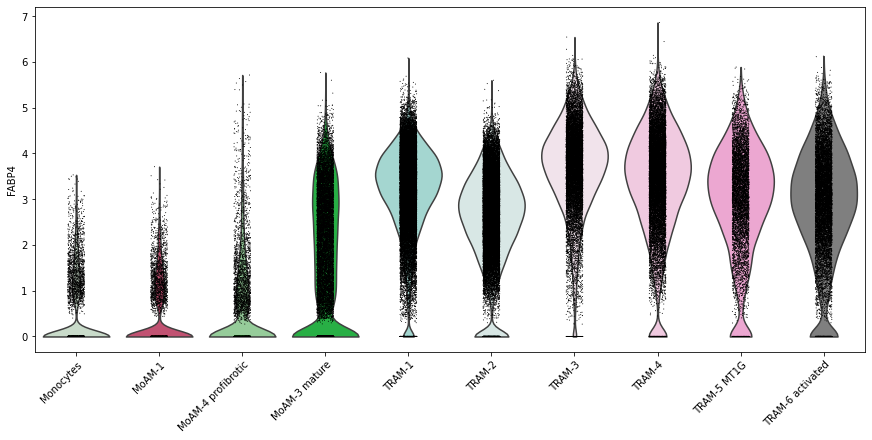

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
sc.pl.violin(
    adata,
    'FABP4',
    groupby='cell_type',
    ax=ax,
    rotation=45,
    show=False,
    order=[
        'Monocytes', 'MoAM-1', 'MoAM-4 profibrotic', 'MoAM-3 mature',
        'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated'
    ]
)
trans = mpl.transforms.Affine2D().translate(8, 0)
for t in ax.get_xticklabels():
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)

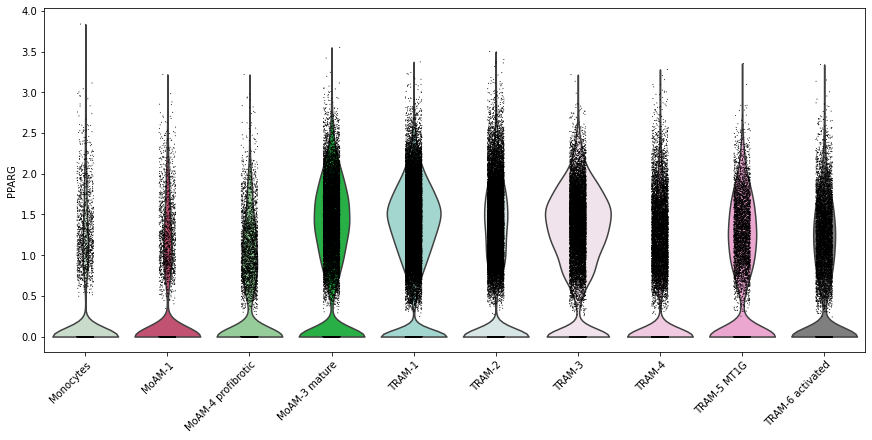

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
sc.pl.violin(
    adata,
    'PPARG',
    groupby='cell_type',
    ax=ax,
    rotation=45,
    show=False,
    order=[
        'Monocytes', 'MoAM-1', 'MoAM-4 profibrotic', 'MoAM-3 mature',
        'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated'
    ]
)
trans = mpl.transforms.Affine2D().translate(8, 0)
for t in ax.get_xticklabels():
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)

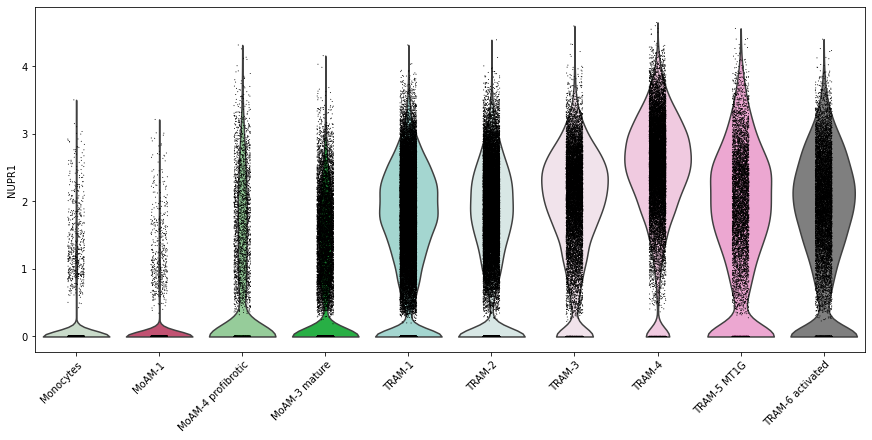

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
sc.pl.violin(
    adata,
    'NUPR1',
    groupby='cell_type',
    ax=ax,
    rotation=45,
    show=False,
    order=[
        'Monocytes', 'MoAM-1', 'MoAM-4 profibrotic', 'MoAM-3 mature',
        'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated'
    ]
)
trans = mpl.transforms.Affine2D().translate(8, 0)
for t in ax.get_xticklabels():
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)

## MoAM-3 gene countour plots

In [131]:
moam3 = adata[adata.obs.cell_type.eq('MoAM-3 mature')]

In [174]:
moam3_expr = sc.get.obs_df(moam3, ['FABP4', 'FCN1', 'VCAN', 'CCL2', 'Status'])

<AxesSubplot:xlabel='FABP4', ylabel='FCN1'>

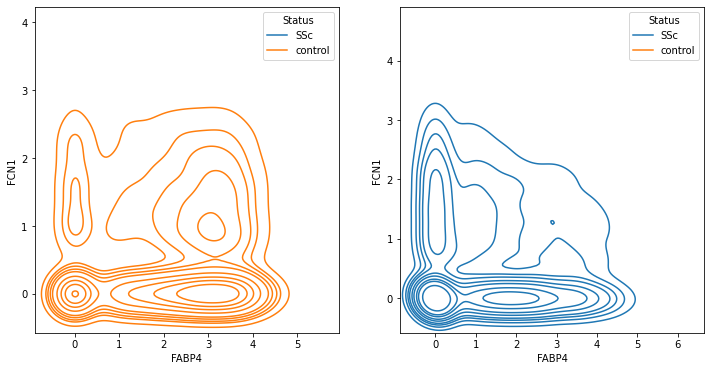

In [175]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.Status.eq('control')],
    x='FABP4',
    y='FCN1',
    hue='Status',
    ax=axes[0]
)
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.Status.eq('SSc')],
    x='FABP4',
    y='FCN1',
    hue='Status',
    ax=axes[1]
)

<AxesSubplot:xlabel='FABP4', ylabel='VCAN'>

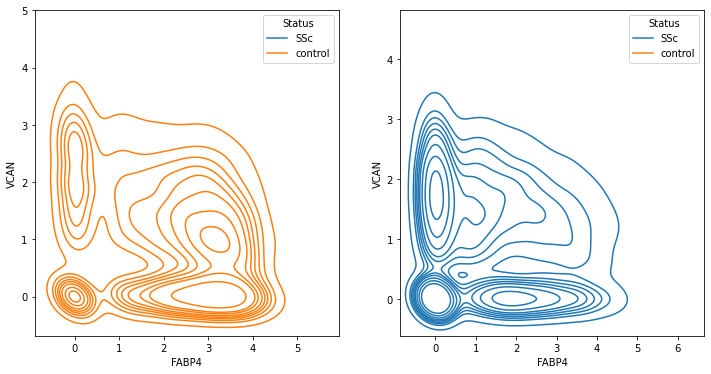

In [176]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.Status.eq('control')],
    x='FABP4',
    y='VCAN',
    hue='Status',
    ax=axes[0]
)
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.Status.eq('SSc')],
    x='FABP4',
    y='VCAN',
    hue='Status',
    ax=axes[1]
)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='FCN1'>

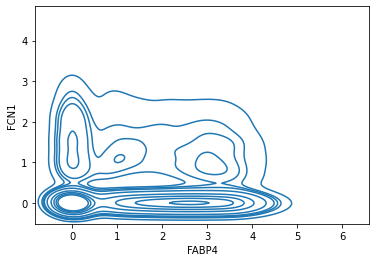

In [133]:
sns.kdeplot(moam3_expr.FABP4, moam3_expr.FCN1)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='VCAN'>

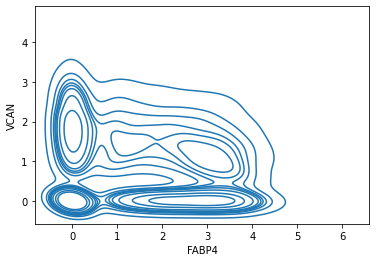

In [134]:
sns.kdeplot(moam3_expr.FABP4, moam3_expr.VCAN)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='CCL2'>

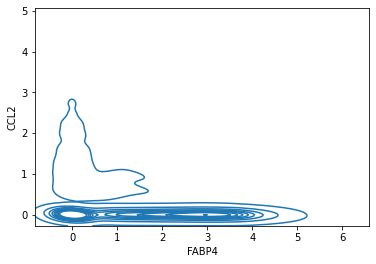

In [135]:
sns.kdeplot(moam3_expr.FABP4, moam3_expr.CCL2)

## MoAM-3 Spectra programs contour plot

In [136]:
adata_spc = sc.read_h5ad('../../data/31_bal-object/14a_spectra/14a_spectra.h5ad')

In [137]:
moam3_spc = adata_spc[adata_spc.obs.cell_type.eq('MoAM-3 mature')]

In [177]:
moam3_spc_expr = sc.get.obs_df(moam3_spc, ['F_75_global', 'F_69_all_LYS_metabolism', 'Status'])

<AxesSubplot:xlabel='F_75_global', ylabel='F_69_all_LYS_metabolism'>

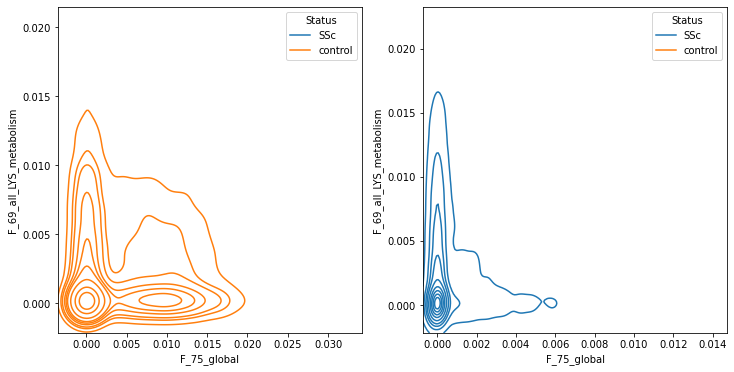

In [179]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.kdeplot(
    data=moam3_spc_expr.loc[moam3_spc_expr.Status.eq('control')],
    x='F_75_global',
    y='F_69_all_LYS_metabolism',
    hue='Status',
    ax=axes[0]
)
sns.kdeplot(
    data=moam3_spc_expr.loc[moam3_spc_expr.Status.eq('SSc')],
    x='F_75_global',
    y='F_69_all_LYS_metabolism',
    hue='Status',
    ax=axes[1]
)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='F_75_global', ylabel='F_69_all_LYS_metabolism'>

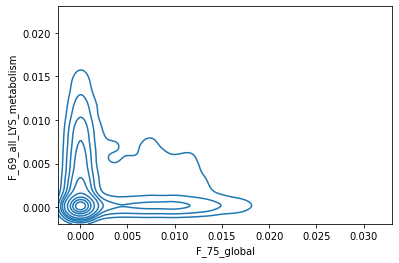

In [139]:
sns.kdeplot(moam3_spc_expr.F_75_global, moam3_spc_expr.F_69_all_LYS_metabolism)

## MoAM-4 gene contour plots

In [140]:
moam4 = adata[adata.obs.cell_type.eq('MoAM-4 profibrotic')]

In [141]:
moam4_expr = sc.get.obs_df(moam4, ['FABP4', 'FCN1', 'VCAN', 'CCL2'])

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='FCN1'>

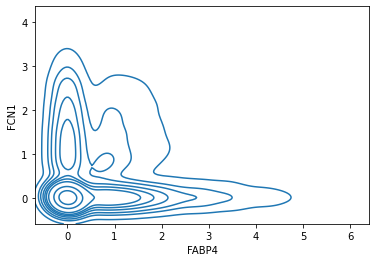

In [142]:
sns.kdeplot(moam4_expr.FABP4, moam4_expr.FCN1)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='VCAN'>

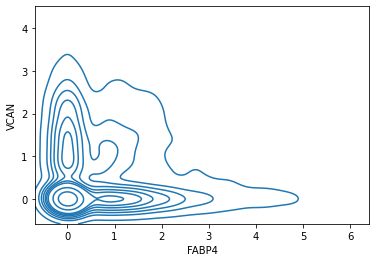

In [143]:
sns.kdeplot(moam4_expr.FABP4, moam4_expr.VCAN)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='CCL2'>

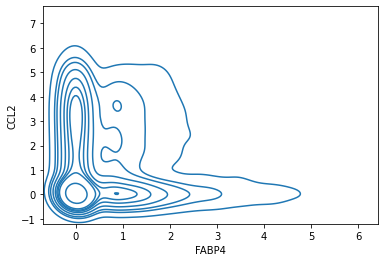

In [144]:
sns.kdeplot(moam4_expr.FABP4, moam4_expr.CCL2)

## TRAM-1 gene countour plots

In [145]:
tram1 = adata[adata.obs.cell_type.eq('TRAM-1')]

In [146]:
tram1_expr = sc.get.obs_df(tram1, ['FABP4', 'FCN1', 'VCAN', 'CCL2'])

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='FCN1'>

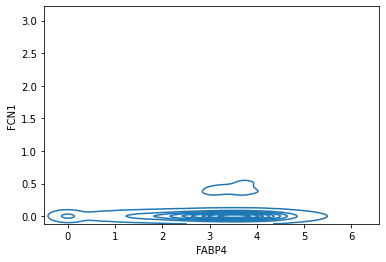

In [147]:
sns.kdeplot(tram1_expr.FABP4, tram1_expr.FCN1)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='VCAN'>

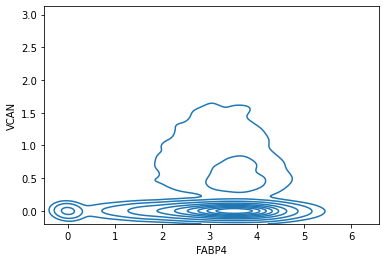

In [148]:
sns.kdeplot(tram1_expr.FABP4, tram1_expr.VCAN)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FABP4', ylabel='CCL2'>

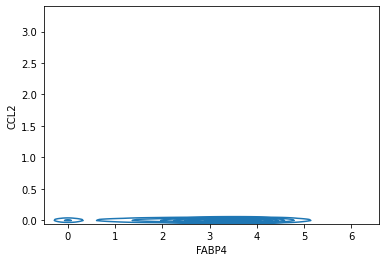

In [149]:
sns.kdeplot(tram1_expr.FABP4, tram1_expr.CCL2)

## Gene coexpression heatmaps

In [151]:
def plot_gene_detection(table, title):
    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    sns.heatmap(
        table.sort_index().values.reshape((2, 2)),
        annot=True,
        fmt='d',
        ax=ax
    )
    ax.set_ylabel(table.index.names[0])
    ax.set_xlabel(table.index.names[1])
    ax.invert_yaxis()
    ax.set_title(title, size=16)
    return ax

<AxesSubplot:title={'center':'MoAM-3'}, xlabel='FCN1', ylabel='FABP4'>

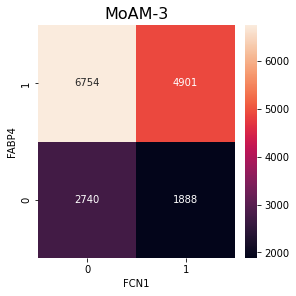

In [154]:
plot_gene_detection(moam3_expr.gt(0).astype(int)[['FABP4', 'FCN1']].value_counts(), 'MoAM-3')

<AxesSubplot:title={'center':'MoAM-3'}, xlabel='VCAN', ylabel='FABP4'>

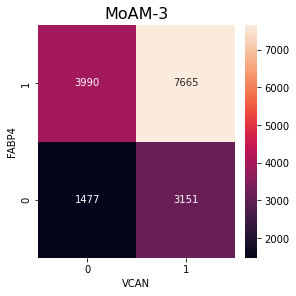

In [155]:
plot_gene_detection(moam3_expr.gt(0).astype(int)[['FABP4', 'VCAN']].value_counts(), 'MoAM-3')

<AxesSubplot:title={'center':'MoAM-4'}, xlabel='FCN1', ylabel='FABP4'>

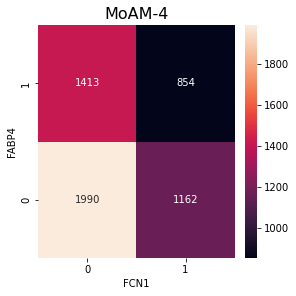

In [152]:
plot_gene_detection(moam4_expr.gt(0).astype(int)[['FABP4', 'FCN1']].value_counts(), 'MoAM-4')

<AxesSubplot:title={'center':'MoAM-4'}, xlabel='VCAN', ylabel='FABP4'>

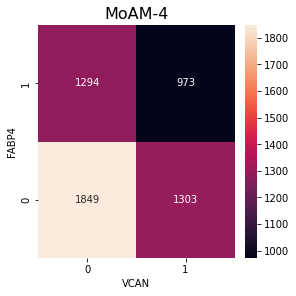

In [153]:
plot_gene_detection(moam4_expr.gt(0).astype(int)[['FABP4', 'VCAN']].value_counts(), 'MoAM-4')

<AxesSubplot:title={'center':'TRAM-1'}, xlabel='FCN1', ylabel='FABP4'>

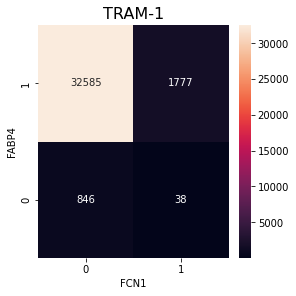

In [156]:
plot_gene_detection(tram1_expr.gt(0).astype(int)[['FABP4', 'FCN1']].value_counts(), 'TRAM-1')

<AxesSubplot:title={'center':'TRAM-1'}, xlabel='VCAN', ylabel='FABP4'>

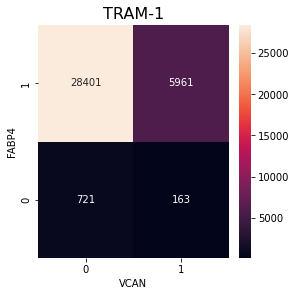

In [157]:
plot_gene_detection(tram1_expr.gt(0).astype(int)[['FABP4', 'VCAN']].value_counts(), 'TRAM-1')

## Split MoAM-3 into 2 clusters, check where the split is

In [159]:
sc.pp.neighbors(moam3, use_rep='X_scVI')

In [160]:
sc.tl.leiden(moam3, resolution=0.2, key_added='cell_type_2')

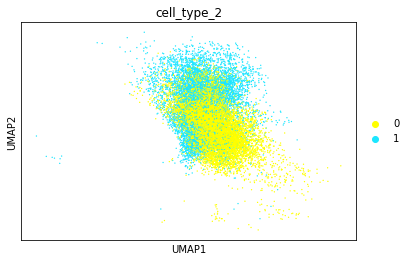

In [161]:
sc.pl.umap(moam3, color='cell_type_2')

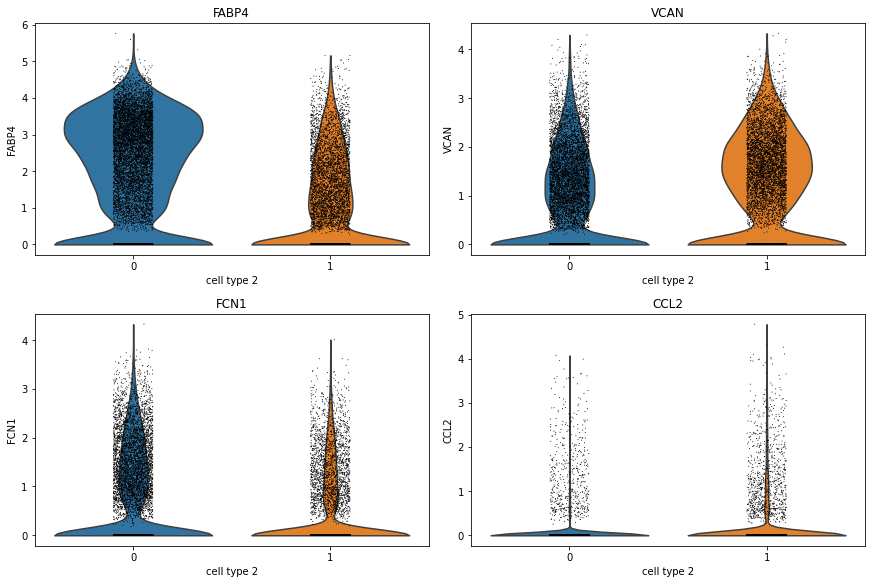

In [162]:
fig, axes = plt.subplots(figsize=(12, 8), nrows=2, ncols=2, constrained_layout=True)
for i, gene in enumerate(('FABP4', 'VCAN', 'FCN1', 'CCL2')):
    ax = axes[i // 2, i % 2]
    sc.pl.violin(moam3, gene, groupby='cell_type_2', ax=ax, show=False)
    ax.set_title(gene)

## Split contour plots

In [163]:
moam3_expr = sc.get.obs_df(moam3, ['FABP4', 'FCN1', 'VCAN', 'CCL2', 'cell_type_2'])

<AxesSubplot:xlabel='FABP4', ylabel='FCN1'>

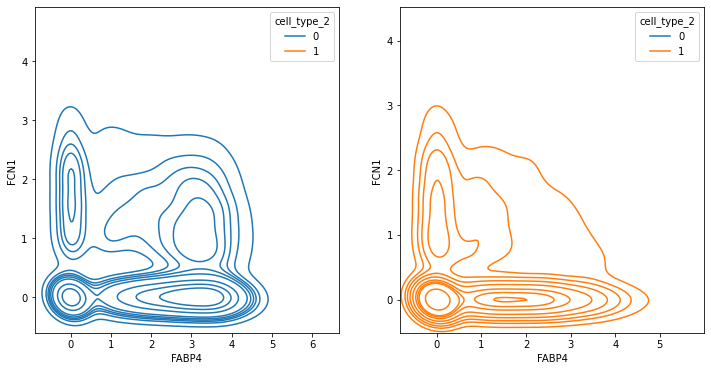

In [172]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.cell_type_2.eq('0')],
    x='FABP4',
    y='FCN1',
    hue='cell_type_2',
    ax=axes[0]
)
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.cell_type_2.eq('1')],
    x='FABP4',
    y='FCN1',
    hue='cell_type_2',
    ax=axes[1]
)

<AxesSubplot:xlabel='FABP4', ylabel='VCAN'>

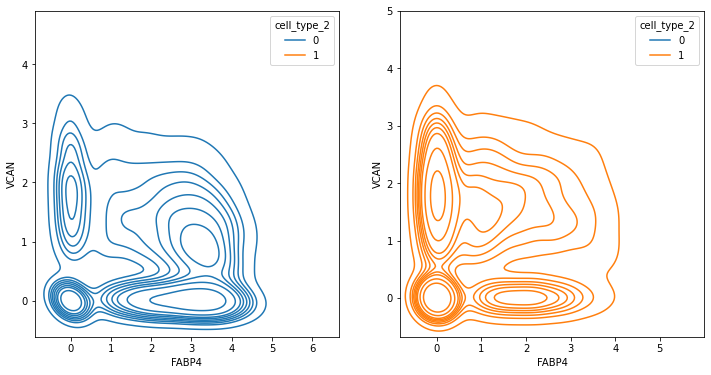

In [173]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.cell_type_2.eq('0')],
    x='FABP4',
    y='VCAN',
    hue='cell_type_2',
    ax=axes[0]
)
sns.kdeplot(
    data=moam3_expr.loc[moam3_expr.cell_type_2.eq('1')],
    x='FABP4',
    y='VCAN',
    hue='cell_type_2',
    ax=axes[1]
)

<AxesSubplot:xlabel='FABP4', ylabel='CCL2'>

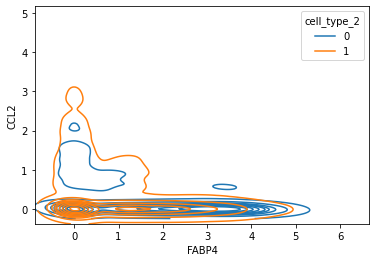

In [166]:
sns.kdeplot(
    data=moam3_expr,
    x='FABP4',
    y='CCL2',
    hue='cell_type_2'
)